# Image Space Projection using Autoencoders
![](./images/faces.gif)

In this example we are going to autoencode the faces of the olivetti dataset and try to reconstruct them back.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [2]:
import h2o
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,2 hours 1 min
H2O cluster version:,3.11.0.99999
H2O cluster version age:,9 hours and 8 minutes
H2O cluster name:,arno
H2O cluster total nodes:,1
H2O cluster free memory:,13.47 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

In [3]:
!wget -c http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.tar.Z

--2016-10-23 01:11:47--  http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.tar.Z
Resolving www.cl.cam.ac.uk (www.cl.cam.ac.uk)... 2001:630:212:200::80:14, 128.232.0.20
Connecting to www.cl.cam.ac.uk (www.cl.cam.ac.uk)|2001:630:212:200::80:14|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att_faces.tar.Z [following]
--2016-10-23 01:11:47--  http://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att_faces.tar.Z
Reusing existing connection to [www.cl.cam.ac.uk]:80.
HTTP request sent, awaiting response... 200 OK
Length: 4075767 (3.9M) [application/x-compress]
Saving to: ‘att_faces.tar.Z’

att_faces.tar.Z     100%[===================>]   3.89M  2.55MB/s    in 1.5s    

2016-10-23 01:11:49 (2.55 MB/s) - ‘att_faces.tar.Z’ saved [4075767/4075767]



In [4]:
!tar xzvf att_faces.tar.Z;rm att_faces.tar.Z;

orl_faces/
orl_faces/README
orl_faces/s1/
orl_faces/s1/6.pgm
orl_faces/s1/7.pgm
orl_faces/s1/8.pgm
orl_faces/s1/9.pgm
orl_faces/s1/10.pgm
orl_faces/s1/1.pgm
orl_faces/s1/2.pgm
orl_faces/s1/3.pgm
orl_faces/s1/4.pgm
orl_faces/s1/5.pgm
orl_faces/s2/
orl_faces/s2/6.pgm
orl_faces/s2/7.pgm
orl_faces/s2/8.pgm
orl_faces/s2/9.pgm
orl_faces/s2/10.pgm
orl_faces/s2/1.pgm
orl_faces/s2/2.pgm
orl_faces/s2/3.pgm
orl_faces/s2/4.pgm
orl_faces/s2/5.pgm
orl_faces/s3/
orl_faces/s3/6.pgm
orl_faces/s3/7.pgm
orl_faces/s3/8.pgm
orl_faces/s3/9.pgm
orl_faces/s3/10.pgm
orl_faces/s3/1.pgm
orl_faces/s3/2.pgm
orl_faces/s3/3.pgm
orl_faces/s3/4.pgm
orl_faces/s3/5.pgm
orl_faces/s4/
orl_faces/s4/6.pgm
orl_faces/s4/7.pgm
orl_faces/s4/8.pgm
orl_faces/s4/9.pgm
orl_faces/s4/10.pgm
orl_faces/s4/1.pgm
orl_faces/s4/2.pgm
orl_faces/s4/3.pgm
orl_faces/s4/4.pgm
orl_faces/s4/5.pgm
orl_faces/s5/
orl_faces/s5/6.pgm
orl_faces/s5/7.pgm
orl_faces/s5/8.pgm
orl_faces/s5/9.pgm
orl_faces/s5/10.pgm
orl_faces/s5/1.pgm
orl_faces/s5/2.pgm
orl_

We now need some code to read pgm files.
Thanks to [StackOverflow](http://stackoverflow.com/questions/7368739/numpy-and-16-bit-pgm) we have some code to leverage:

In [5]:
import re

def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))


In [6]:
image = read_pgm("orl_faces/s12/6.pgm", byteorder='<')

In [7]:
image.shape

(112, 92)

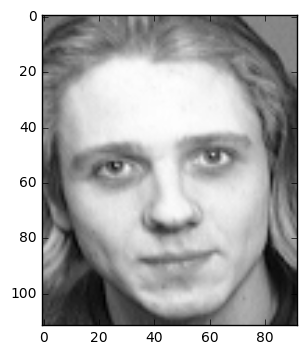

In [8]:
plt.imshow(image, plt.cm.gray)
plt.show()

In [9]:
import glob
import os
from collections import defaultdict

In [10]:
images = glob.glob("orl_faces/**/*.pgm")

data = defaultdict(list)
image_data = []
for img in images:
    _,label,_ = img.split(os.path.sep)
    imgdata = read_pgm(img, byteorder='<').flatten().tolist()
    data[label].append(imgdata)
    image_data.append(imgdata)

Let's import it to H2O

In [11]:
faces = h2o.H2OFrame(image_data)

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


In [12]:
faces.shape

(400, 10304)

In [13]:
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator

In [15]:
model = H2OAutoEncoderEstimator( 
        activation="Tanh", 
        hidden=[50], 
        l1=1e-4, 
        epochs=10
)

model.train(x=faces.names, training_frame=faces)

deeplearning Model Build progress: |██████████████████████████████████████████████████████████| 100%


In [16]:
model

Model Details
H2OAutoEncoderEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1477202989522_3315
Status of Neuron Layers: auto-encoder, gaussian distribution, Quadratic loss, 1,040,754 weights/biases, 13.0 MB, 4,000 training samples, mini-batch size 1



,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
,1,10304,Input,0.0,,,,,,,,,
,2,50,Tanh,0.0,0.0001,0.0,0.0007149,0.0002085,0.0,0.0002015,0.0198808,0.0081105,0.1122776
,3,10304,Tanh,,0.0001,0.0,0.0049906,0.0019985,0.0,0.0003122,0.0250720,0.0011189,0.0135767




ModelMetricsAutoEncoder: deeplearning
** Reported on train data. **

MSE: 0.0150895996476
RMSE: 0.122839731551
Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_mse
,2016-10-23 01:12:20,1.372 sec,0.00000 obs/sec,0.0,0,0.0,0.2161652,0.0467274
,2016-10-23 01:12:26,6.921 sec,370 obs/sec,5.0,5,2000.0,0.1310679,0.0171788
,2016-10-23 01:12:31,12.148 sec,342 obs/sec,9.0,9,3600.0,0.1246621,0.0155406
,2016-10-23 01:12:32,13.363 sec,345 obs/sec,10.0,10,4000.0,0.1228397,0.0150896


## Reconstructing the hidden space

Now that we have our model trained, we would like to understand better what is the internal representation of this model? What makes a face a .. face? 

We will provide to the model some gaussian noise and see what is the results.

We star by creating some gaussian noise:

In [17]:
import pandas as pd

In [18]:
gaussian_noise = np.random.randn(10304)

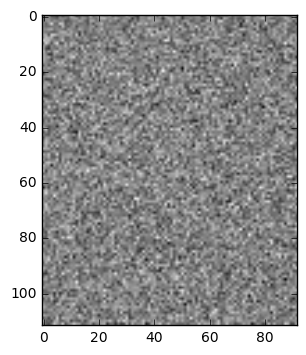

In [19]:
plt.imshow(gaussian_noise.reshape(112, 92), plt.cm.gray);

Then we import this data inside H2O. We have to first map the columns to the gaussian data.

In [20]:
gaussian_noise_pre = dict(zip(faces.names,gaussian_noise))

In [21]:
gaussian_noise_hf = h2o.H2OFrame.from_python(gaussian_noise_pre)

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


In [22]:
result = model.predict(gaussian_noise_hf)

deeplearning prediction progress: |███████████████████████████████████████████████████████████| 100%


In [28]:
result.shape

(1, 10304)

In [29]:
img = result.as_data_frame()

In [30]:
img_data = img.T.values.reshape(112, 92)

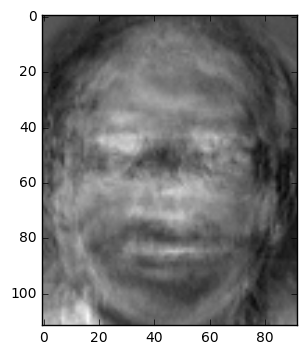

In [31]:
plt.imshow(img_data, plt.cm.gray);